# Regridding (WRF-Chem)

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import numpy as np
import xarray as xr
import xesmf as xe
from xgcm.autogenerate import generate_grid_ds
from xgcm import Grid
from scipy import stats

Set range of longitude/latitude and the rsolution of grid we want.

In [2]:
resolution = 1 # degree
Lat_min = 20; Lat_max = 50
Lon_min = -115; Lon_max = -65

Read file and drop time dimension.
We need to rename the coordinate names to `lon` and `lat` because xESMF has no way to guess variable meaning.

Source of wrfout

In [3]:
filename = 'Files/wrfout_lnox_extracted.nc'
ds = xr.open_dataset(filename).isel(Time=0)
ds.rename({'XLONG':'lon','XLAT':'lat'}, inplace=True)

/home/xin/Software/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:3: FutureWarning: The inplace argument has been deprecated and will be removed in xarray 0.12.0.
  This is separate from the ipykernel package so we can avoid doing imports until


<xarray.Dataset>
Dimensions:        (bottom_top: 29, south_north: 269, west_east: 429)
Coordinates:
    lat            (south_north, west_east) float32 ...
    lon            (south_north, west_east) float32 ...
Dimensions without coordinates: bottom_top, south_north, west_east
Data variables:
    CG_FLASHCOUNT  (south_north, west_east) float32 ...
    IC_FLASHCOUNT  (south_north, west_east) float32 ...
    P              (bottom_top, south_north, west_east) float32 ...
    PB             (bottom_top, south_north, west_east) float32 ...
    no2            (bottom_top, south_north, west_east) float32 ...
Attributes:
    TITLE:                            OUTPUT FROM *             PROGRAM:WRF/C...
    START_DATE:                      2014-04-01_00:00:00
    SIMULATION_START_DATE:           2014-04-01_00:00:00
    WEST-EAST_GRID_DIMENSION:        430
    SOUTH-NORTH_GRID_DIMENSION:      270
    BOTTOM-TOP_GRID_DIMENSION:       30
    DX:                              12000.0
    DY:        

Create the nested grid we want

In [4]:
nested_grid = xe.util.grid_2d(Lon_min-resolution/2, Lon_max+resolution/2, resolution,  # longitude boundary range and resolution
                        Lat_min-resolution/2, Lat_max+resolution/2, resolution)  # latitude boundary range and resolution
nested_grid

<xarray.Dataset>
Dimensions:  (x: 51, x_b: 52, y: 31, y_b: 32)
Coordinates:
    lon      (y, x) float64 -115.0 -114.0 -113.0 -112.0 ... -67.0 -66.0 -65.0
    lat      (y, x) float64 20.0 20.0 20.0 20.0 20.0 ... 50.0 50.0 50.0 50.0
    lon_b    (y_b, x_b) float64 -115.5 -114.5 -113.5 ... -66.5 -65.5 -64.5
    lat_b    (y_b, x_b) float64 19.5 19.5 19.5 19.5 19.5 ... 50.5 50.5 50.5 50.5
Dimensions without coordinates: x, x_b, y, y_b
Data variables:
    *empty*

Because `FLASHCOUNT` has extensive properties, it should be divide by cell area first (discussed in this [issue](https://github.com/JiaweiZhuang/xESMF/issues/44)).
We need to calculate the cell area for `bilinear` and `conservative` regridding.

To calculate cell area or use conservative regridding,
we need to specify the cell boundaries,
since the boundary information is needed for calculating overlapping areas (thus ensures total mass conservation).

I decide to converting 2D coordinates from cell center to bound with [xgcm.autogenerate](https://gist.github.com/jbusecke/175d72d81e13f7f8d4dcf26aace511bd).

In [5]:
# Generate outer dimensions from center input
ds_post = generate_grid_ds(ds, {'X':'west_east', 'Y':'south_north'}, position=('center', 'outer'))

# Generate the 2d coordinates for the cell boundaries
# with the "standard" xgcm interpolation for each logical dimension
grid_ds = Grid(ds_post, periodic=False)
bnd='extrapolate'
ds_post.coords['xb'] = grid_ds.interp(grid_ds.interp(ds_post['lon'], 'X', boundary=bnd, fill_value=np.nan),
                                          'Y', boundary=bnd, fill_value=np.nan)
ds_post.coords['yb'] = grid_ds.interp(grid_ds.interp(ds_post['lat'], 'X', boundary=bnd, fill_value=np.nan),
                                          'Y', boundary=bnd, fill_value=np.nan)

wrf_grid_with_bounds = {'lon': ds['lon'].values,
                         'lat': ds['lat'].values,
                         'lon_b': ds_post.xb.data,
                         'lat_b': ds_post.yb.data,
                       }

area_wrf = xe.util.cell_area(wrf_grid_with_bounds)
area_grid = xe.util.cell_area(nested_grid)

## Bilinear regridding

In [6]:
regridder_bilinear = xe.Regridder(ds, nested_grid, method='bilinear')

Overwrite existing file: bilinear_269x429_31x51.nc 
 You can set reuse_weights=True to save computing time.


 Loop over all variables in an xarray Dataset and choose what we want.

In [7]:
bilinear_list = [] # an emtpy list to hold regridding result

for varname, dr in ds.data_vars.items():
  # Olny pick variables we need
  if varname in ['IC_FLASHCOUNT','CG_FLASHCOUNT']:
    dr_temp = regridder_bilinear(dr/area_wrf)  # temporary variable for the current tracer
    bilinear_list.append(dr_temp)
  elif varname == 'no2':
    dr_temp = regridder_bilinear(dr)
    bilinear_list.append(dr_temp)

We can merge a list of DataArray to a single Dataset

In [8]:
bilinear_result = xr.merge(bilinear_list)  # merge a list of DataArray to a single Dataset
# NOTE: The next version of xESMF (v0.2) will be able to directly regrid a Dataset, 
# so you will not need those additional code. But it is a nice coding exercise anyway.
bilinear_result

<xarray.Dataset>
Dimensions:        (bottom_top: 29, x: 51, y: 31)
Coordinates:
    lon            (y, x) float64 -115.0 -114.0 -113.0 ... -67.0 -66.0 -65.0
    lat            (y, x) float64 20.0 20.0 20.0 20.0 ... 50.0 50.0 50.0 50.0
  * bottom_top     (bottom_top) int64 0 1 2 3 4 5 6 7 ... 22 23 24 25 26 27 28
Dimensions without coordinates: x, y
Data variables:
    CG_FLASHCOUNT  (y, x) float64 0.0 0.0 0.0 0.0 0.0 ... 6.518e-05 0.0 0.0 0.0
    IC_FLASHCOUNT  (y, x) float64 0.0 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0 0.0 0.0
    no2            (bottom_top, y, x) float64 0.0 0.0 0.0 ... 0.0003715 0.0 0.0

Calculate a new variable and save it to Dataset

In [9]:
bilinear_result['TL_FLASHCOUNT'] =  (bilinear_result.CG_FLASHCOUNT + bilinear_result.IC_FLASHCOUNT) * area_grid #TL  = IC +CG

it's good practice to supply array attributes such as `units` and description.

In [10]:
# Set attributes
bilinear_result['no2'].attrs['description'] = 'NO2 mixing ratio'
bilinear_result['no2'].attrs['units'] = 'ppmv'
bilinear_result['IC_FLASHCOUNT'].attrs['description'] = 'Accumulated IC flash count'
bilinear_result['CG_FLASHCOUNT'].attrs['description'] = 'Accumulated CG flash count'
bilinear_result['TL_FLASHCOUNT'].attrs['description'] = 'Accumulated Total flash count'

## Conservative regridding

Like before, we can regrid and create Dataset now

In [11]:
regridder_conserve = xe.Regridder(wrf_grid_with_bounds, nested_grid, method='conservative')

conservative_list = []

for varname, dr in ds.data_vars.items():
  if varname in ['IC_FLASHCOUNT','CG_FLASHCOUNT']:
    dr_temp = regridder_conserve(dr/area_wrf)
    conservative_list.append(dr_temp)
  elif varname == 'no2':
    dr_temp = regridder_conserve(dr)
    conservative_list.append(dr_temp)

conservative_result = xr.merge(conservative_list)

conservative_result['TL_FLASHCOUNT'] =  (conservative_result.CG_FLASHCOUNT + conservative_result.IC_FLASHCOUNT) * area_grid

# Set attributes
conservative_result['no2'].attrs['description'] = 'NO2 mixing ratio'
conservative_result['no2'].attrs['units'] = 'ppmv'
conservative_result['IC_FLASHCOUNT'].attrs['description'] = 'Accumulated IC flash count'
conservative_result['CG_FLASHCOUNT'].attrs['description'] = 'Accumulated CG flash count'
conservative_result['TL_FLASHCOUNT'].attrs['description'] = 'Accumulated Total flash count'

Overwrite existing file: conservative_269x429_31x51.nc 
 You can set reuse_weights=True to save computing time.


## nearest_d2s regridding

In [12]:
regridder_nearest_d2s = xe.Regridder(ds, nested_grid, method='nearest_d2s')

nearest_d2s_list = [] # an emtpy list to hold regridding result

for varname, dr in ds.data_vars.items():
  # Olny pick variables we need
  if varname in ['IC_FLASHCOUNT','CG_FLASHCOUNT','no2']:
    dr_temp = regridder_nearest_d2s(dr)  # temporary variable for the current tracer
    nearest_d2s_list.append(dr_temp)

nearest_d2s_result = xr.merge(nearest_d2s_list)
nearest_d2s_result['TL_FLASHCOUNT'] =  nearest_d2s_result.CG_FLASHCOUNT + nearest_d2s_result.IC_FLASHCOUNT

# Set attributes
nearest_d2s_result['no2'].attrs['description'] = 'NO2 mixing ratio'
nearest_d2s_result['no2'].attrs['units'] = 'ppmv'
nearest_d2s_result['IC_FLASHCOUNT'].attrs['description'] = 'Accumulated IC flash count'
nearest_d2s_result['CG_FLASHCOUNT'].attrs['description'] = 'Accumulated CG flash count'
nearest_d2s_result['TL_FLASHCOUNT'].attrs['description'] = 'Accumulated Total flash count'

Overwrite existing file: nearest_d2s_269x429_31x51.nc 
 You can set reuse_weights=True to save computing time.


## 'True' regridding

Since 12 km ~ 0.1&deg;, we can regrid the data to 0.1&deg; * 0.1&deg; by any mthod first and sum to 1&deg; * 1&deg; later.

I decide to use `bilinear` to create the `True` regirdding.

In [13]:
resolution_true = 0.1
resolution_sum = 1

# Set grids for two kinds of resolution
nested_grid = xe.util.grid_2d(Lon_min-resolution_true, Lon_max+resolution_true, resolution_true,
                        Lat_min-resolution_true, Lat_max+resolution_true, resolution_true)
large_grid = xe.util.grid_2d(Lon_min-resolution_sum, Lon_max+resolution_sum, resolution_sum,
                        Lat_min-resolution_sum, Lat_max+resolution_sum, resolution_sum)

regridder_true = xe.Regridder(ds, nested_grid, method='bilinear', reuse_weights=True)
regridder_sum = xe.Regridder(ds, large_grid, method='bilinear', reuse_weights=True)

true_list = []
sum_list = []

for varname, dr in ds.data_vars.items():
  # Olny pick variables we need
  if varname in ['IC_FLASHCOUNT','CG_FLASHCOUNT']:
    dr_true = regridder_true(dr)
    dr_sum = regridder_sum(dr)
    true_list.append(dr_true)
    sum_list.append(dr_sum)

true_result = xr.merge(true_list)
sum_result = xr.merge(sum_list)
true_result['TL_FLASHCOUNT'] =  true_result.CG_FLASHCOUNT + true_result.IC_FLASHCOUNT

# Sum the flashcounts from 0.1 degree to 1 degree
TL_flashcount = stats.binned_statistic_2d(nested_grid['lat'].values.ravel(), nested_grid['lon'].values.ravel(), true_result.TL_FLASHCOUNT.values.ravel(), \
                                                        'sum', bins=[large_grid['lat_b'].values[:,0],large_grid['lon_b'].values[0]]).statistic.reshape(sum_result['IC_FLASHCOUNT'].shape)

sum_result['TL_FLASHCOUNT'] = (('y', 'x'), TL_flashcount)

Reuse existing file: bilinear_269x429_302x502.nc
Reuse existing file: bilinear_269x429_32x52.nc


/home/xin/Software/anaconda3/lib/python3.6/site-packages/scipy/stats/_binned_statistic.py:607: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  result = result[core]


## Comparison

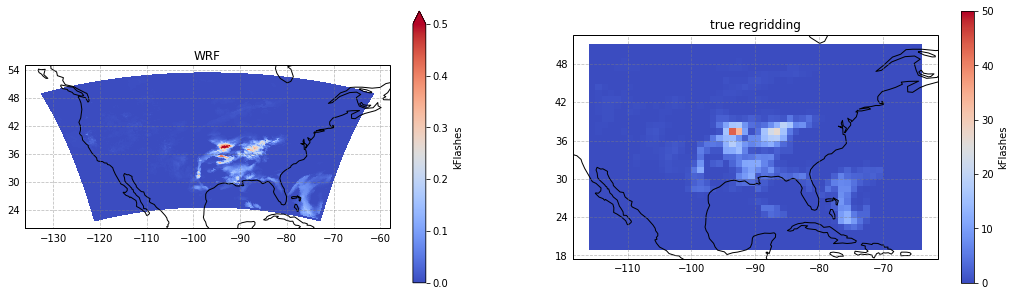

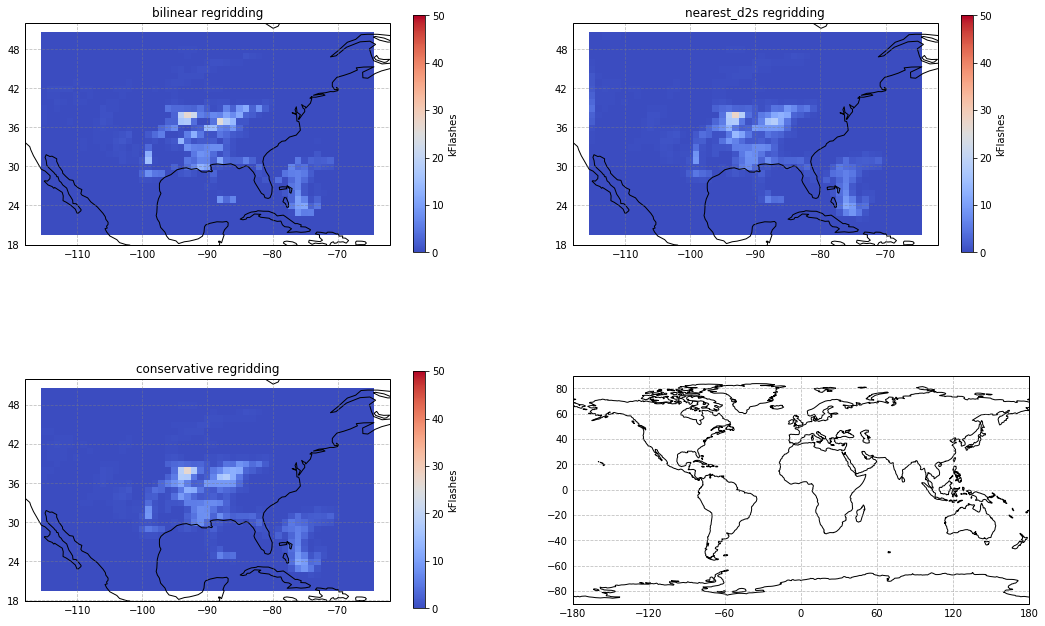

In [14]:
TL_true = sum_result['TL_FLASHCOUNT']/1E3 # kFlashes
TL_bilinear = bilinear_result['TL_FLASHCOUNT']/1E3
TL_conservative = conservative_result['TL_FLASHCOUNT']/1E3
TL_nearest_d2s = nearest_d2s_result['TL_FLASHCOUNT']/1E3

# Create Lambert Projection
proj = ccrs.PlateCarree()

fig, axes = plt.subplots(1,2,figsize=[18,10], subplot_kw={'projection': proj})
# Plot WRF data
TL = (ds['CG_FLASHCOUNT']+ds['IC_FLASHCOUNT'])/1E3 # kFlashes
TL.plot(ax=axes.flatten()[0], cmap='coolwarm', transform=ccrs.PlateCarree(), x='lon', y='lat', vmin=0, vmax=0.5,
                        cbar_kwargs={'shrink': 0.5, 'label': 'kFlashes'},infer_intervals=True)

# Plot True data
TL_true.plot(ax=axes.flatten()[1], cmap='coolwarm', transform=ccrs.PlateCarree(), x='lon', y='lat', vmin=0, vmax=50,
                        cbar_kwargs={'shrink': 0.5, 'label': 'kFlashes'},infer_intervals=True)

for ax in axes.flatten():
    ax.coastlines()
    gl = ax.gridlines(draw_labels=True, color='gray', alpha=0.5, linestyle='--')
    gl.xlabels_top=False; gl.ylabels_right=False

axes.flatten()[0].set_title('WRF')
axes.flatten()[1].set_title('true regridding')


fig, axes = plt.subplots(2, 2, figsize=[18,12], subplot_kw={'projection': proj})
# Plot Bilinear data
TL_bilinear.plot(ax=axes.flatten()[0], cmap='coolwarm', transform=ccrs.PlateCarree(), x='lon', y='lat', vmin=0, vmax=50,
                                   cbar_kwargs={'shrink': 0.8, 'label': 'kFlashes'},infer_intervals=True)

# Plot nearest_d2s data
TL_nearest_d2s.plot(ax=axes.flatten()[1], cmap='coolwarm', transform=ccrs.PlateCarree(), x='lon', y='lat', vmin=0, vmax=50,
                                   cbar_kwargs={'shrink': 0.8, 'label': 'kFlashes'},infer_intervals=True)

# Plot Conservative data
TL_conservative.plot(ax=axes.flatten()[2], cmap='coolwarm', transform=ccrs.PlateCarree(), x='lon', y='lat', vmin=0, vmax=50,
                                      cbar_kwargs={'shrink': 0.8, 'label': 'kFlashes'},infer_intervals=True)

axes.flatten()[0].set_title('bilinear regridding')
axes.flatten()[1].set_title('nearest_d2s regridding')
axes.flatten()[2].set_title('conservative regridding')

for ax in axes.flatten():
    ax.coastlines()
    gl = ax.gridlines(draw_labels=True, color='gray', alpha=0.5, linestyle='--')
    gl.xlabels_top=False; gl.ylabels_right=False

Since 1&deg; * 1&deg; consists of ~ 100 cells (12 km), I scale the colorbar by `100`.

It looks like `nearest_d2s` and `conservative` get the similar result, while `bilinear` keeps the original distribution but little larger.